<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Домашнее-задание.-Классификация-изображений" data-toc-modified-id="Домашнее-задание.-Классификация-изображений-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Домашнее задание. Классификация изображений</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Установка-зависимостей" data-toc-modified-id="Установка-зависимостей-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Установка зависимостей</a></span></li><li><span><a href="#Функция-паралельной-подгрузки" data-toc-modified-id="Функция-паралельной-подгрузки-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Функция паралельной подгрузки</a></span></li><li><span><a href="#Посмотрим-распределение" data-toc-modified-id="Посмотрим-распределение-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Посмотрим распределение</a></span></li><li><span><a href="#Построение-нейросети-Baseline-+-Net_1" data-toc-modified-id="Построение-нейросети-Baseline-+-Net_1-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>Построение нейросети Baseline + Net_1</a></span></li><li><span><a href="#Net2" data-toc-modified-id="Net2-1.0.5"><span class="toc-item-num">1.0.5&nbsp;&nbsp;</span>Net2</a></span></li><li><span><a href="#Net_3" data-toc-modified-id="Net_3-1.0.6"><span class="toc-item-num">1.0.6&nbsp;&nbsp;</span>Net_3</a></span></li><li><span><a href="#Функции-для-обучения-и-тестирования-сетки" data-toc-modified-id="Функции-для-обучения-и-тестирования-сетки-1.0.7"><span class="toc-item-num">1.0.7&nbsp;&nbsp;</span>Функции для обучения и тестирования сетки</a></span></li><li><span><a href="#Инициализация-модели-и-обучение" data-toc-modified-id="Инициализация-модели-и-обучение-1.0.8"><span class="toc-item-num">1.0.8&nbsp;&nbsp;</span>Инициализация модели и обучение</a></span></li><li><span><a href="#Сеть-Net_1" data-toc-modified-id="Сеть-Net_1-1.0.9"><span class="toc-item-num">1.0.9&nbsp;&nbsp;</span>Сеть Net_1</a></span></li></ul></li></ul></li></ul></div>

# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:

import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
"""from google.colab import drive
drive.mount('/content/gdrive/')"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')"

In [ ]:
!nvidia-smi
torch.cuda.is_available()

Tue Mar 14 16:23:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path



from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler

import math
import random
import torch.nn.functional as F
from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import seaborn as sns
import pandas as pd

from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")


In [ ]:
DEVICE

device(type='cuda')

### Функция паралельной подгрузки 

In [ ]:
augmenters_for_duppl = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1),
    'VertFlip':transforms.RandomVerticalFlip(p=1),
    'Perspective':transforms.RandomPerspective(distortion_scale=0.3, p=1.0)
    
}


In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        augmenter = random.choice(list(augmenters_for_duppl.values()))
        image = augmenter(image)
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
!cp -r /kaggle/input/journey-springfield/testset/testset ./

!cp -r /kaggle/input/journey-springfield/train/simpsons_dataset ./

In [ ]:
TRAIN_DIR = Path('/kaggle/working/simpsons_dataset')
TEST_DIR = Path('/kaggle/working/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

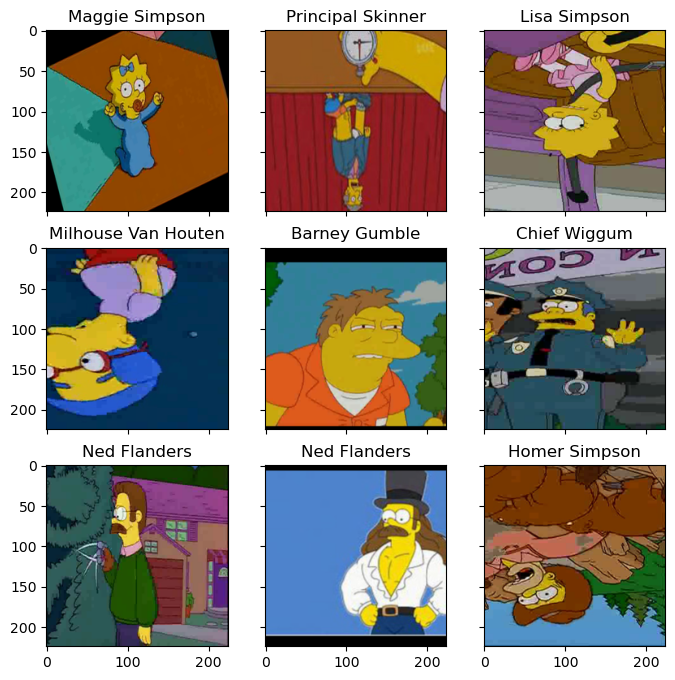

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(val_dataset)))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Посмотрим распределение

In [ ]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

In [ ]:
def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    if max_level:
        plt.axhline(y=1500)
    if min_level:
        plt.axhline(y=100, color='red')
    plt.show()

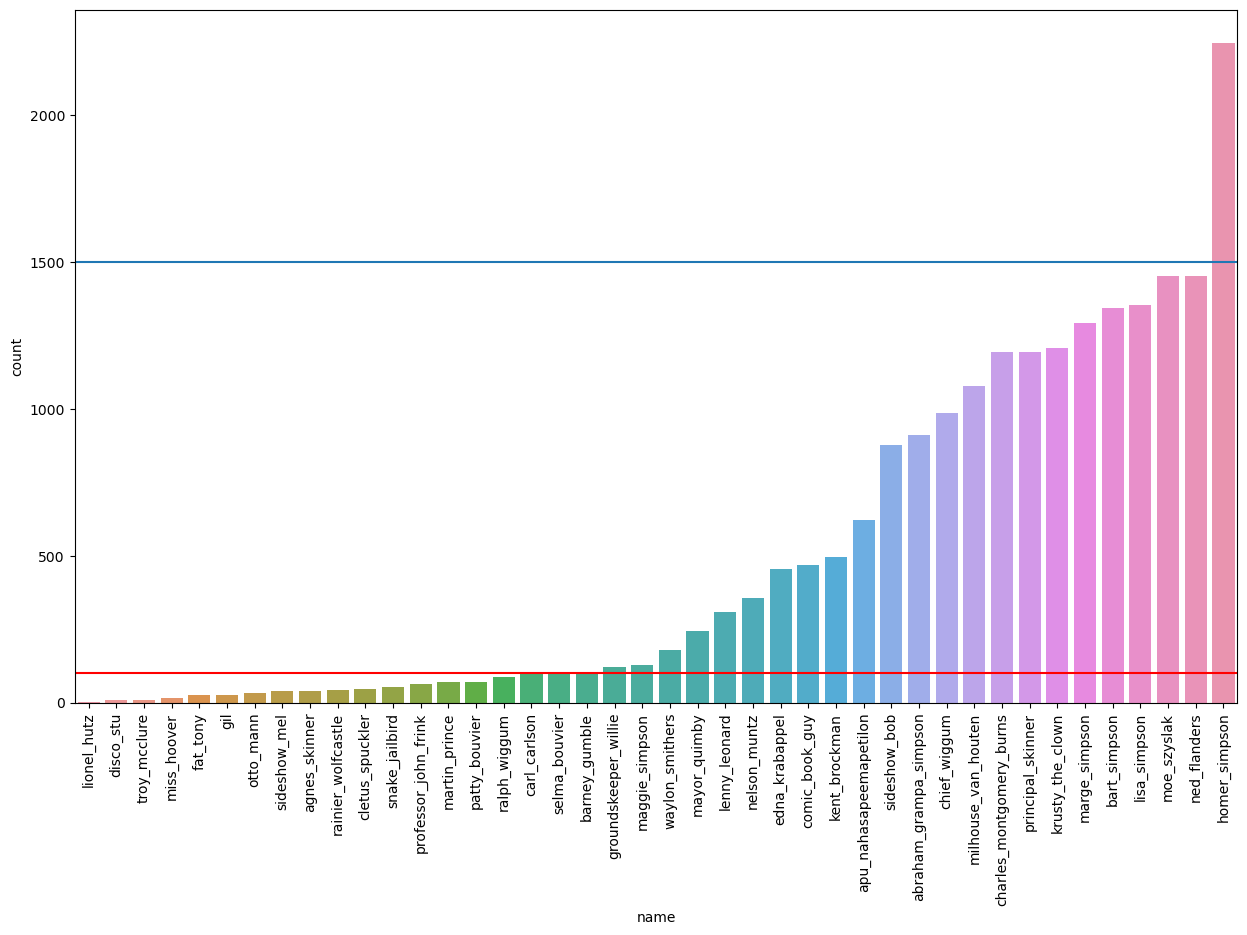

In [ ]:
show_data(get_count([path.parent.name for path in train_val_files]))

С таким распределением далеко не уедешь, нужно это решать.

In [ ]:
data=get_count([path.parent.name for path in train_val_files])
data['to_add'] = data['count'].apply(lambda x: 2000 - x if x < 2000 else 0)
data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)

In [ ]:
data

,count,to_add,one_iteration
name,,,
lionel_hutz,3,1997,666
disco_stu,8,1992,249
troy_mcclure,8,1992,249
miss_hoover,17,1983,117
fat_tony,27,1973,74
gil,27,1973,74
otto_mann,32,1968,62
sideshow_mel,40,1960,49
agnes_skinner,42,1958,47


In [ ]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}



In [ ]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

In [ ]:
for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    # if we don't need to add any images, we can continue without transformation
    if data.loc[character]['to_add'] <= 0:
        continue

    # if number of images to create for one iteration is greater than the rest of images to create,
    # we should use 'to_add' instead of 'one_iteration'  
    if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:
        iter_size = data.loc[character]['to_add']
    else:
        iter_size = data.loc[character]['one_iteration']
    data.loc[character]['to_add'] -= iter_size
    
    for i in range(iter_size):
        augmenter = random.choice(list(augmenters_for_duppl.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

100%|██████████| 20933/20933 [07:01<00:00, 49.65it/s]  


In [ ]:
TRAIN_DIR = Path('/kaggle/working/simpsons_dataset')
TEST_DIR = Path('/kaggle/working/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
len(train_val_files)

84246

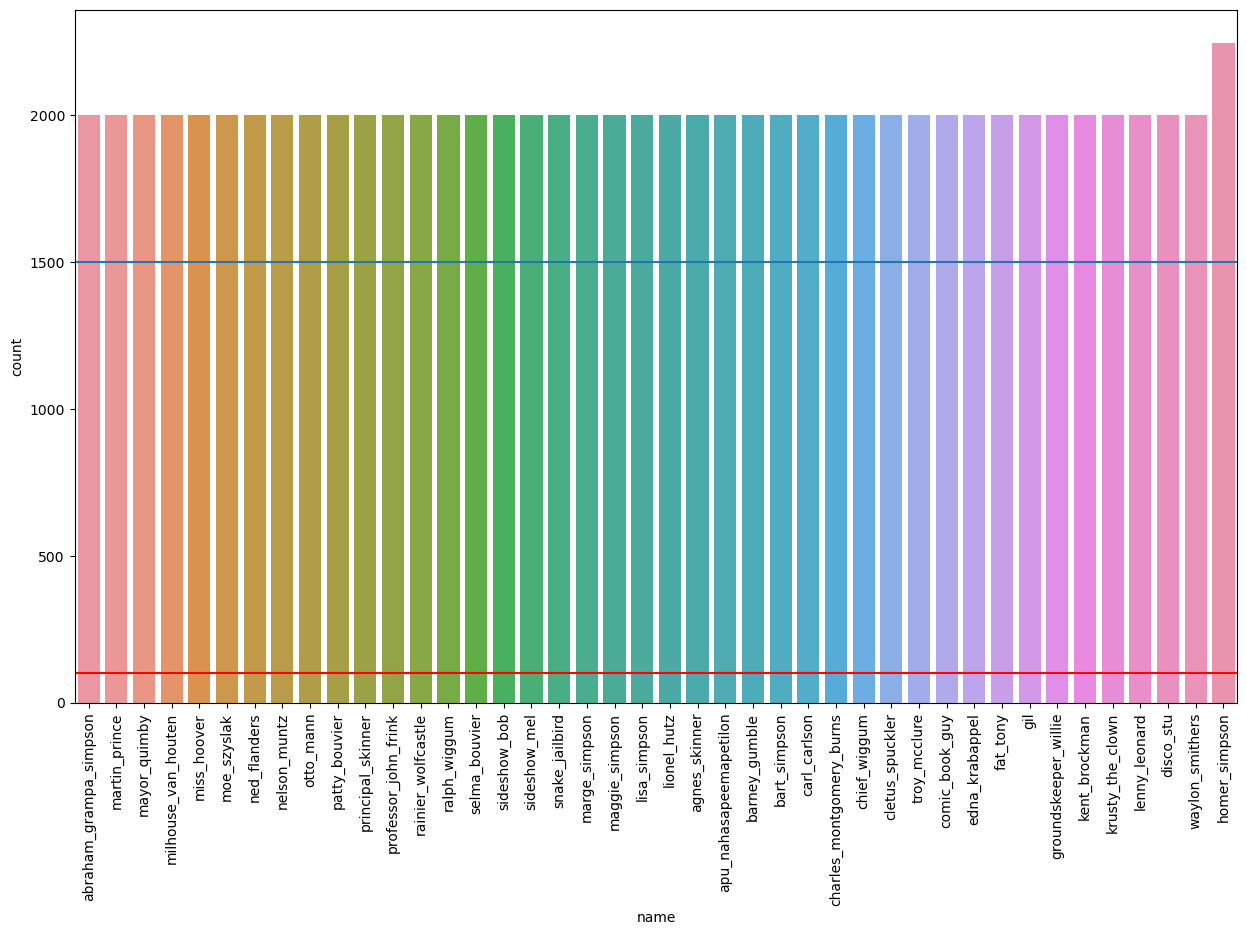

In [ ]:
show_data(get_count([path.parent.name for path in train_val_files]))

Благодаря аугменатции данных я сгенерировал дополнительные фото персонажей так, чтобы для каждого было минимум 2000 фоток. Так мы избавимся от дисбаланса классов.
Ну все, теперь работаем

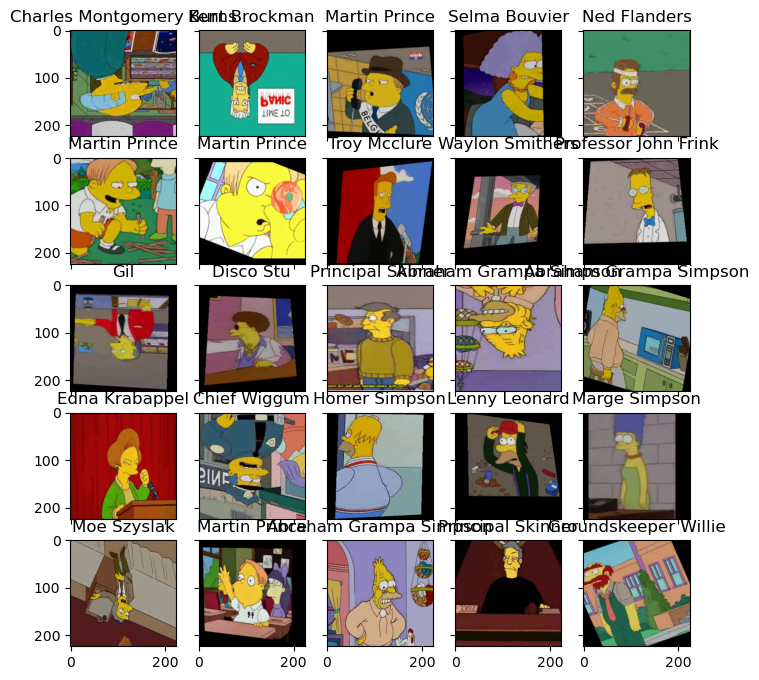

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(val_dataset)))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
              title=img_label,plt_ax=fig_x)

### Построение нейросети Baseline + Net_1



*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


размерность равна картинка на вход n*n
stride =s
kernel=k
карта активации = a*a
a=(n-k)/s+1

In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(128 * 1 * 1, 64 )
        self.out = nn.Linear(64 , n_classes)
  
  
    def forward(self, x):
        
        x = self.conv1(x)
        skip=x
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #x+=skip
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view( -1,128)
        x = F.elu(self.fc1(x))
        logits = self.out(x)
        return logits

Далее будут различные варианты моей дополнительно модернизации сети

In [ ]:
class Net_1(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=56, kernel_size=3),
            nn.BatchNorm2d(56),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=56, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3),
            nn.BatchNorm2d(2048),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(2048 * 1 * 1, 1024 )
        self.fc2 = nn.Linear(1024 * 1 * 1, 512 )
        self.out = nn.Linear(512 , n_classes)
        self.dropout = nn.Dropout(p=0.25)
  
  
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #skip=x
        #print(x.shape)
        x = self.conv5(x)
        x = self.conv6(x)
        #print(x.shape)
        x = x.view( -1,2048)
        x = self.dropout(F.relu(self.fc1(x)))

        x = F.relu(self.fc2(x))
        #x+=skip.view( -1,512*12*12)

        logits = self.out(x)
        return logits

### Net2


In [ ]:
class Net_2_2(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.dropout = nn.Dropout(p=0.25)
        
        self.fc1 = nn.Linear(1024 * 1 * 1, 2048 )
        self.fc2 = nn.Linear(2048 * 1 * 1, 1024 )
        self.out = nn.Linear(1024 , n_classes)
  
  
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #skip=x
        #print(x.shape)
        x = self.conv5(x)
        x = self.conv6(x)
        #print(x.shape)
        x = x.view( -1,1024)
        x = self.dropout(F.relu(self.fc1(x)))
        

        x = F.relu(self.fc2(x))
        #x+=skip.view( -1,512*12*12)

        logits = self.out(x)
        return logits

### Net_3

Далее я решил спроектировать сети с применение skip connection. Однако данные сети получись весьма тяжелые, а результат их не превышал Net1. Далее я выполнил схему этой сети, это было интересно)

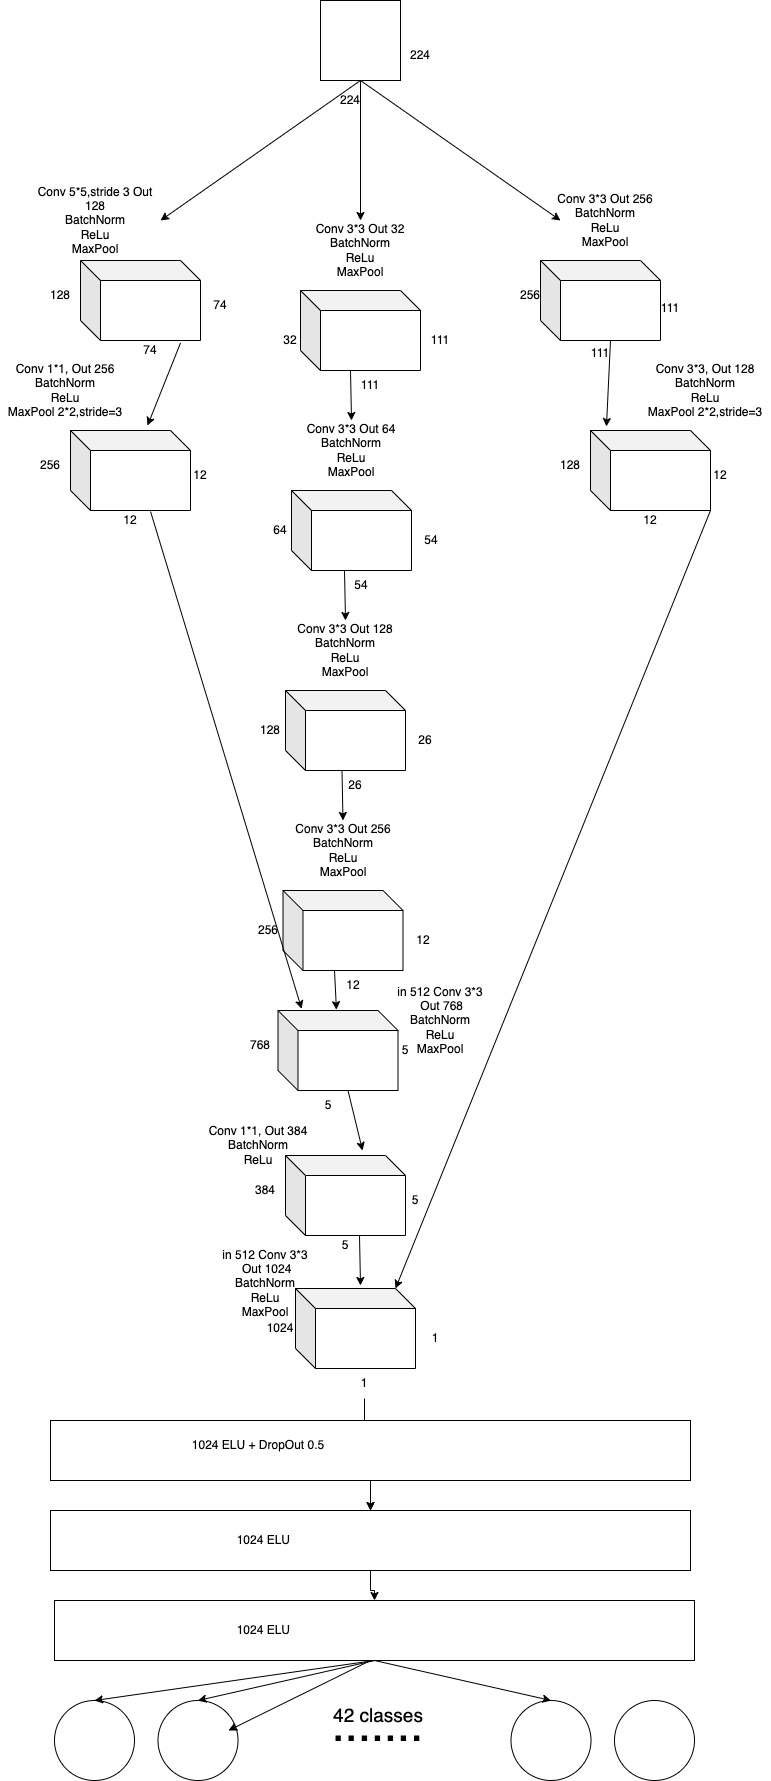

In [ ]:
class Net_3(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv55 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5,stride=3),#224-5)/1+1=220
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=3)
            
        )#128*37*37--256*
            
            
        self.conv_rgb = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3,stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=3),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3,stride=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=3,padding=1)
            #111
        )
            
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#54
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#26
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#12
        )
        #in5 drom others
            
            
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=768, kernel_size=3),
            nn.BatchNorm2d(768),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=768, out_channels=384, kernel_size=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
            
        )#5*5
        
        #768+256=1024
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(1024 * 1 * 1, 1024 )
        self.fc2 = nn.Linear(1024 * 1 * 1, 1024 )
        self.out = nn.Linear(1024 , n_classes)
  
  
    def forward(self, x):
        y = self.conv55(x)
        rgb = self.conv_rgb(x)
        
        #print('rgb',rgb.shape)
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #skip=x
        
        k=torch.cat((x, y), 1)
        #print('koncat',k.shape)
        #x+=y
        #print('conv4+55',x.shape)
        
        x = self.conv5(k)
        #print('conv5',x.shape)
        #x+=rgb
        rgb_=torch.cat((x, rgb), 1)
        x = self.conv6(rgb_)
        #print('conv6',x.shape)
        x = x.view( -1,1024)
        x = self.dropout(F.elu(self.fc1(x)))

        x = F.elu(self.fc2(x))
        #x+=skip.view( -1,512*12*12)

        logits = self.out(x)
        return logits


In [ ]:
class Net_4(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv55 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5,stride=3),#224-5)/1+1=220
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=3)
            
        )#128*37*37--256*
            
            
        self.conv_rgb = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=3),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,stride=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=3,padding=1)
            #111
        )
            
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#54
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#26
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#12
        )
        #in5 drom others
            
            
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),nn.MaxPool2d(kernel_size=2)
            
        )#5*5
        
        #768+256=1024
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=2048, kernel_size=3),
            nn.BatchNorm2d(2048),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(2048 * 1 * 1, 2048 )
        self.fc2 = nn.Linear(2048 * 1 * 1, 1024 )
        self.out = nn.Linear(1024 , n_classes)
  
  
    def forward(self, x):
        y = self.conv55(x)
        rgb = self.conv_rgb(x)
        
        #print('rgb',rgb.shape)
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #skip=x
        
        k=torch.cat((x, y), 1)
        #print('koncat',k.shape)
        #x+=y
        #print('conv4+55',x.shape)
        
        x = self.conv5(k)
        #print('conv5',x.shape)
        #x+=rgb
        rgb_=torch.cat((x, rgb), 1)
        x = self.conv6(rgb_)
        #print('conv6',x.shape)
        x = x.view( -1,2048)
        x = self.dropout(F.relu(self.fc1(x)))

        x = F.relu(self.fc2(x))
        #x+=skip.view( -1,512*12*12)

        logits = self.out(x)
        return logits


### Функции для обучения и тестирования сетки

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer,exp_lr_scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    exp_lr_scheduler.step()         
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(),lr=1e-5)
        criterion = nn.CrossEntropyLoss()
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=5, gamma=0.2)#Добавлю планировщик на снижение LR

        for epoch in range(epochs):
            print('**','LR=',opt.state_dict()['param_groups'][0]['lr'],'**')
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt,exp_lr_scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Инициализация модели и обучение

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = Net_1(n_classes)
print("we will classify :{}".format(n_classes))
print(simple_cnn)
'''simple_cnn= nn.DataParallel(simple_cnn)
simple_cnn.to(DEVICE)'''

we will classify :42
Net_1(
  (conv1): Sequential(
    (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(56, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

'simple_cnn= nn.DataParallel(simple_cnn)\nsimple_cnn.to(DEVICE)'

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
simple_cnn= nn.DataParallel(simple_cnn)

In [ ]:
#model = Net_1(n_classes, **kwargs)
simple_cnn.load_state_dict(torch.load('/kaggle/input/new-cnn-2it/Net_1_big_aug_2it (1).dat'))

<All keys matched successfully>

In [ ]:

simple_cnn.to(DEVICE)

DataParallel(
  (module): Net_1(
    (conv1): Sequential(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(56, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): Bat

In [ ]:

history = train(train_dataset, val_dataset, model=simple_cnn, epochs=18, batch_size=150)

epoch:   0%|          | 0/18 [00:00<?, ?it/s]

** LR= 1e-05 **
loss 0.23343051083266994


epoch:   6%|▌         | 1/18 [14:40<4:09:32, 880.71s/it]


Epoch 001 train_loss: 0.2334     val_loss 0.1182 train_acc 0.9303 val_acc 0.9653
** LR= 1e-05 **
loss 0.09438513060046705


epoch:  11%|█         | 2/18 [28:49<3:49:54, 862.18s/it]


Epoch 002 train_loss: 0.0944     val_loss 0.0765 train_acc 0.9723 val_acc 0.9772
** LR= 1e-05 **
loss 0.07322061438047342


epoch:  17%|█▋        | 3/18 [43:05<3:34:44, 858.94s/it]


Epoch 003 train_loss: 0.0732     val_loss 0.0733 train_acc 0.9784 val_acc 0.9786
** LR= 1e-05 **
loss 0.06651311429815308


epoch:  22%|██▏       | 4/18 [57:27<3:20:44, 860.36s/it]


Epoch 004 train_loss: 0.0665     val_loss 0.0699 train_acc 0.9802 val_acc 0.9799
** LR= 1e-05 **
loss 0.05994250920383794


epoch:  28%|██▊       | 5/18 [1:11:47<3:06:21, 860.12s/it]


Epoch 005 train_loss: 0.0599     val_loss 0.0668 train_acc 0.9832 val_acc 0.9808
** LR= 2.0000000000000003e-06 **
loss 0.057279094812094936


epoch:  33%|███▎      | 6/18 [1:25:59<2:51:29, 857.47s/it]


Epoch 006 train_loss: 0.0573     val_loss 0.0646 train_acc 0.9836 val_acc 0.9818
** LR= 2.0000000000000003e-06 **
loss 0.054815623887152776


epoch:  39%|███▉      | 7/18 [1:40:13<2:37:01, 856.46s/it]


Epoch 007 train_loss: 0.0548     val_loss 0.0636 train_acc 0.9839 val_acc 0.9804
** LR= 2.0000000000000003e-06 **
loss 0.056330691211993925


epoch:  44%|████▍     | 8/18 [1:54:30<2:22:45, 856.59s/it]


Epoch 008 train_loss: 0.0563     val_loss 0.0645 train_acc 0.9841 val_acc 0.9815
** LR= 2.0000000000000003e-06 **
loss 0.053536793856521554


epoch:  50%|█████     | 9/18 [2:08:39<2:08:08, 854.27s/it]


Epoch 009 train_loss: 0.0535     val_loss 0.0619 train_acc 0.9842 val_acc 0.9820
** LR= 2.0000000000000003e-06 **
loss 0.054105961957508754


epoch:  56%|█████▌    | 10/18 [2:22:58<1:54:05, 855.64s/it]


Epoch 010 train_loss: 0.0541     val_loss 0.0647 train_acc 0.9852 val_acc 0.9811
** LR= 4.000000000000001e-07 **
loss 0.0546890203911644


epoch:  61%|██████    | 11/18 [2:37:58<1:41:24, 869.28s/it]


Epoch 011 train_loss: 0.0547     val_loss 0.0605 train_acc 0.9841 val_acc 0.9826
** LR= 4.000000000000001e-07 **
loss 0.054263136605996076


epoch:  67%|██████▋   | 12/18 [2:52:41<1:27:19, 873.24s/it]


Epoch 012 train_loss: 0.0543     val_loss 0.0635 train_acc 0.9847 val_acc 0.9827
** LR= 4.000000000000001e-07 **
loss 0.05329947763776683


epoch:  72%|███████▏  | 13/18 [3:06:50<1:12:10, 866.14s/it]


Epoch 013 train_loss: 0.0533     val_loss 0.0616 train_acc 0.9847 val_acc 0.9821
** LR= 4.000000000000001e-07 **
loss 0.05291187780107426


epoch:  78%|███████▊  | 14/18 [3:21:36<58:07, 871.97s/it]  


Epoch 014 train_loss: 0.0529     val_loss 0.0606 train_acc 0.9853 val_acc 0.9819
** LR= 4.000000000000001e-07 **
loss 0.0524013840868085


epoch:  83%|████████▎ | 15/18 [3:37:27<44:47, 895.88s/it]


Epoch 015 train_loss: 0.0524     val_loss 0.0637 train_acc 0.9852 val_acc 0.9819
** LR= 8.000000000000003e-08 **
loss 0.0536499581631453


epoch:  89%|████████▉ | 16/18 [3:52:54<30:10, 905.24s/it]


Epoch 016 train_loss: 0.0536     val_loss 0.0649 train_acc 0.9847 val_acc 0.9820
** LR= 8.000000000000003e-08 **
loss 0.0521089850349956


epoch:  94%|█████████▍| 17/18 [4:08:10<15:08, 908.53s/it]


Epoch 017 train_loss: 0.0521     val_loss 0.0616 train_acc 0.9855 val_acc 0.9821
** LR= 8.000000000000003e-08 **
loss 0.05279088505868286


epoch: 100%|██████████| 18/18 [4:23:18<00:00, 877.67s/it]


Epoch 018 train_loss: 0.0528     val_loss 0.0594 train_acc 0.9851 val_acc 0.9828


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

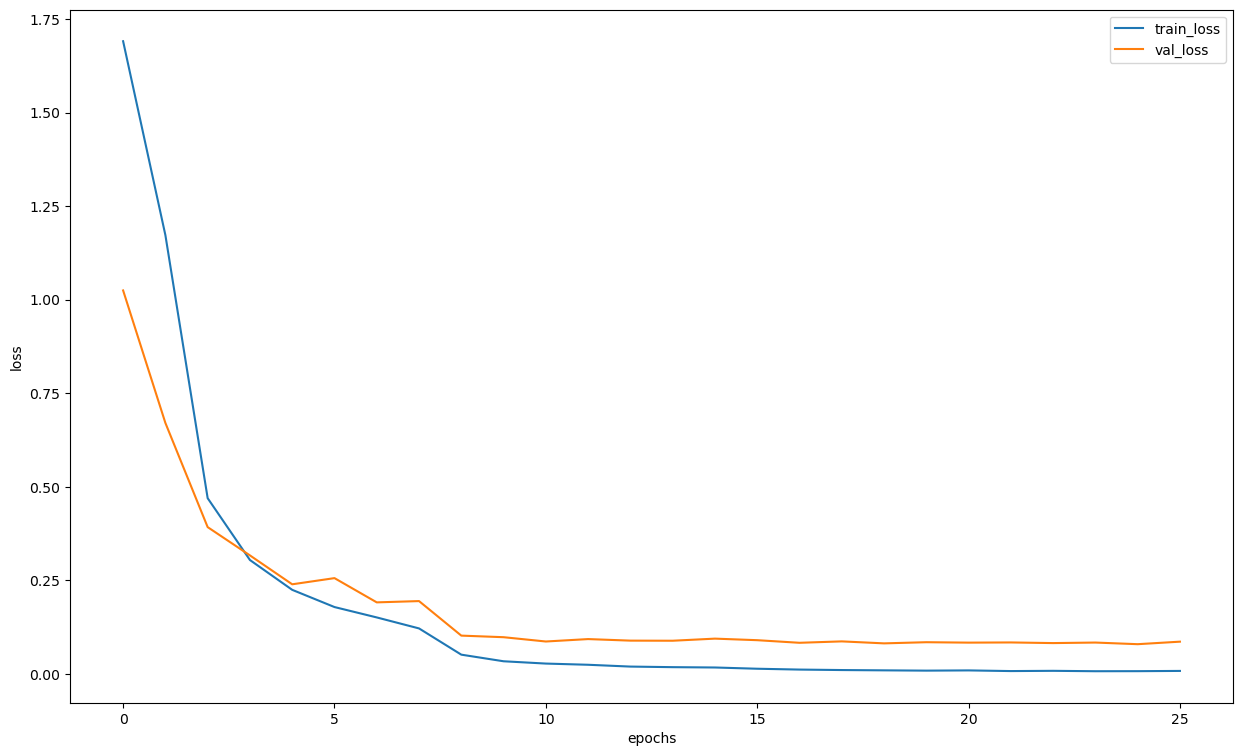

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

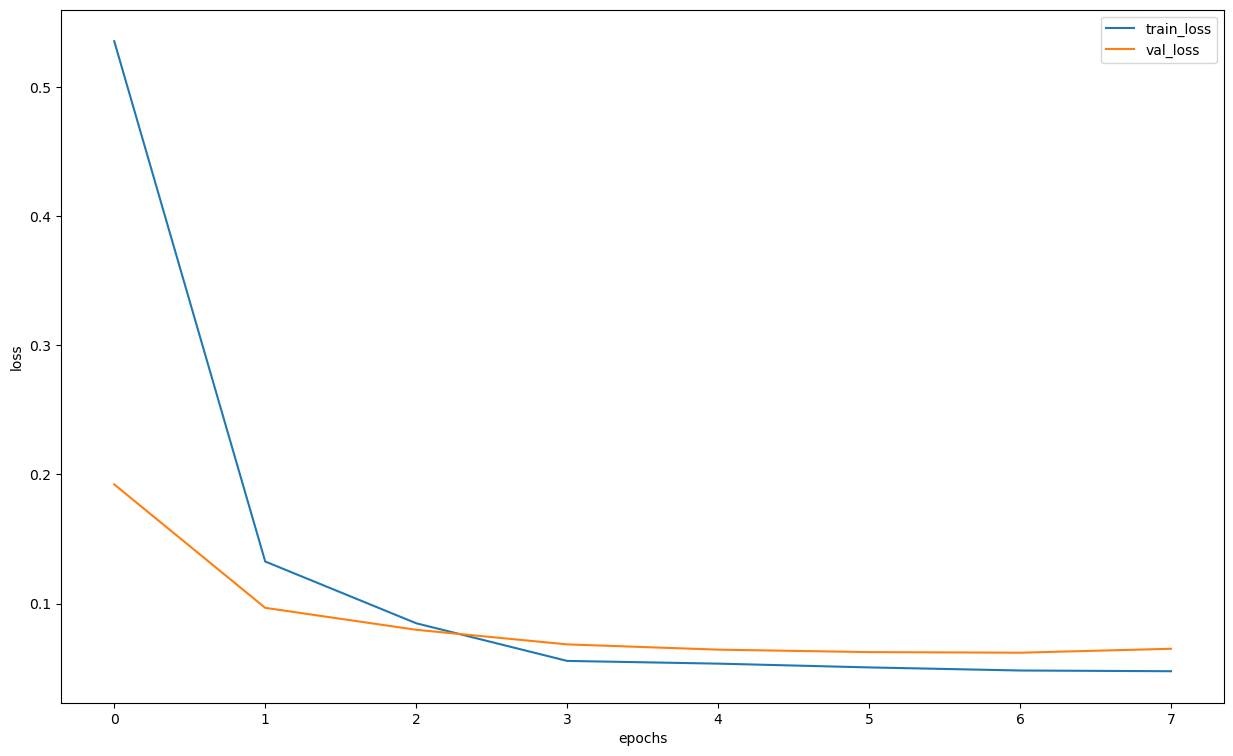

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

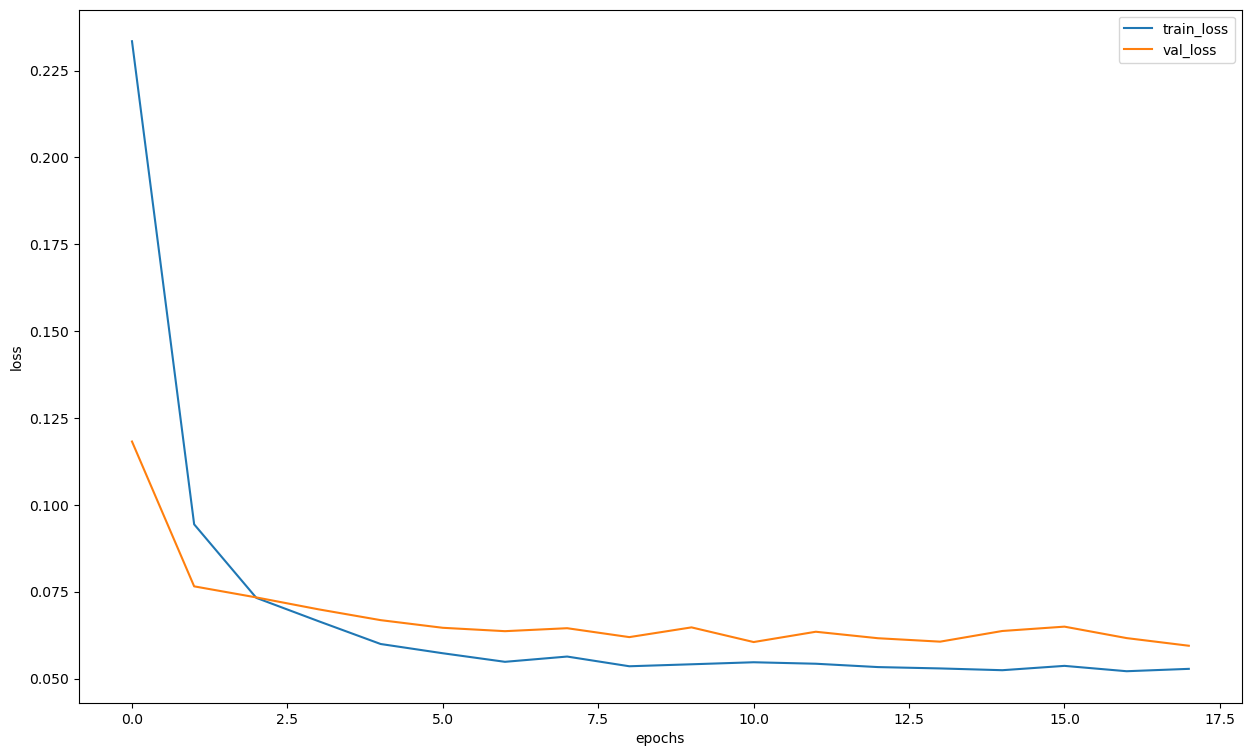

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
len(val_dataset)

16850

In [ ]:
random_characters = int(np.random.uniform(0,15000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,len(val_dataset), 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

label_id = label_encoder.transform(preds_class)


Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
actual_labels

[17, 14, 0, 15, 2, 7, 8, 39, 32, 37, 15, 35, 10, 23, 8, 6, 0, 29, 25, 38]

In [ ]:
preds_class

['krusty_the_clown',
 'groundskeeper_willie',
 'abraham_grampa_simpson',
 'homer_simpson',
 'apu_nahasapeemapetilon',
 'chief_wiggum',
 'cletus_spuckler',
 'snake_jailbird',
 'principal_skinner',
 'sideshow_bob',
 'homer_simpson',
 'ralph_wiggum',
 'disco_stu',
 'martin_prince',
 'cletus_spuckler',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'nelson_muntz',
 'milhouse_van_houten',
 'sideshow_mel']

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, label_id,average='macro')


1.0

Да, на валидации модель показывает феерическсие результаты, но ее еще ждет Kaggle!

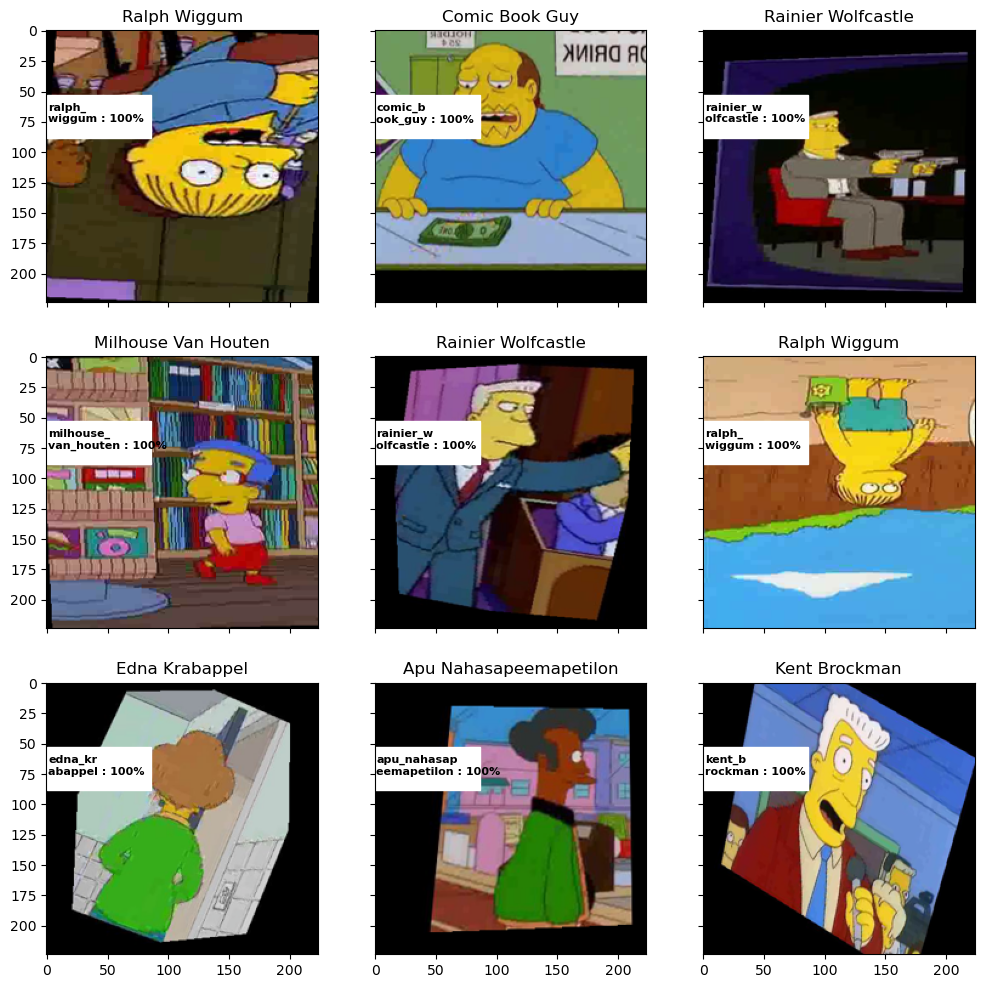

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(val_dataset)))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

In [ ]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('/kaggle/working/net1_big_3.csv', index=False)

### Сеть Net_1 

Имеет скор 0.98193 на Kaggle.

Датасет был без аугментации и расширен до 1500 фото каждого песонажа

Опитмайзер Adam

Далее я пытался расширить аугументациями датасет до 2-4 тысяч фото каждого персонажа, но это не увенчалось успехом. Так же я спроектировал сеть со skip connection (смотри Net_3), это был полет моей фантазии и безумия) Модель получилась тяжелая, долго училась, а результат не улучшала